This Jupyter notebook visualizes the errors from df_results_summary comparing the accuracy of each model and specification for spatial lags.

# imports

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest, f_regression
import math

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

import statsmodels.api as sm

import scipy.stats as stats

from sklearn.feature_selection import RFE
import spreg
# import cudf

import seaborn as sns

import swifter
from scipy.stats import yeojohnson
import warnings
warnings.filterwarnings("ignore")

import sys
from io import StringIO

# Temporarily redirect stdout
old_stdout = sys.stdout


In [2]:
import xgboost
xgboost.__version__

'2.0.3'

## Pickle for results saving

In [3]:
# Pickle a file and then compress it into a file with extension 
import bz2
import pickle
import _pickle as cPickle

def compressed_pickle(title, data):
    with bz2.BZ2File(title + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)
    
# Load any compressed pickle file
def decompress_pickle(file):
    data = bz2.BZ2File(file + '.pbz2', 'rb')
    # data = cPickle.load(data)

    data = pd.compat.pickle_compat.load(data) # for pandas >2.0?
    
    return data

In [4]:
from matplotlib.font_manager import FontProperties

# !!! change it to your path
personal_path = '/cluster/home/jaargota/Fonts/'

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt


# Find the custom font
custom_fonts = fm.findSystemFonts(fontpaths=personal_path, fontext='ttf')

# Add the custom fonts to Matplotlib
for font in custom_fonts:
    fm.fontManager.addfont(font)

# Print the names of custom fonts to verify
for font in custom_fonts:
    print(fm.FontProperties(fname=font).get_name())

# Update the font cache (this will refresh the Matplotlib font list)
plt.rcParams.update({'font.family': 'sans-serif'})

Helvetica
Helvetica
Helvetica
Helvetica Light
Helvetica
Helvetica Compressed


In [5]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

In [6]:
# matplotlib.font_manager.findSystemFonts(fontpaths=personal_path, fontext='ttf')
# plt.rcParams['font.family']=[font_path]
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Helvetica"]

# Load data results

In [15]:
target = "daily_flow"
# features = vars_c_10007_log
features_name = "vars_c_10007_log"

In [17]:
df_results_summary = pd.read_pickle(f"../../01-data/results_summary_error_for_{target}_w_{features_name}.pkl")

In [8]:
df_results_summary

,R-squared,MAE,RMSE,SQV,RATIO,CPC,CPL,model
0,0.047627,22.415743,203.511958,85.270177,0.325945,0.238896,0.418422,OLS_base
1,0.036472,22.407423,237.994681,85.208602,0.333159,0.244648,0.416297,OLS_base
2,0.040216,22.604808,213.166068,84.954795,0.328766,0.241719,0.416241,OLS_base
3,0.034416,22.487371,243.006864,84.891719,0.335300,0.244114,0.414185,OLS_base
4,0.038094,21.362243,215.071401,85.306221,0.346019,0.248190,0.416241,OLS_base
...,...,...,...,...,...,...,...,...
23995,0.873640,5.240616,79.515352,96.523293,0.946569,0.872659,0.748276,Hurdle_XGB_SDM
23996,0.863653,6.312952,96.245086,96.538311,0.968087,0.854830,0.754702,Hurdle_XGB_SDM
23997,0.879097,5.374229,91.957975,96.696002,0.939037,0.879521,0.749117,Hurdle_XGB_SDM
23998,0.677765,5.985032,104.901223,96.662962,0.935645,0.852739,0.747628,Hurdle_XGB_SDM


sorting data

In [30]:
set(df_results_summary.model)

{'Hurdle_XGB_SAR_d',
 'Hurdle_XGB_SAR_o',
 'Hurdle_XGB_SAR_odw',
 'Hurdle_XGB_SAR_w',
 'Hurdle_XGB_SDM_odw',
 'Hurdle_XGB_SLX_od',
 'Hurdle_XGB_SLX_odw',
 'Hurdle_XGB_base',
 'OLS_SAR_d',
 'OLS_SAR_o',
 'OLS_SAR_odw',
 'OLS_SAR_w',
 'OLS_SDM_odw',
 'OLS_SLX_od',
 'OLS_SLX_odw',
 'OLS_base',
 'XGB_SAR_d',
 'XGB_SAR_o',
 'XGB_SAR_odw',
 'XGB_SAR_w',
 'XGB_SDM_odw',
 'XGB_SLX_od',
 'XGB_SLX_odw',
 'XGB_base'}

In [31]:
ordered_models = [
    'OLS_base',
    'OLS_SAR_odw',
    'OLS_SAR_o',
    'OLS_SAR_d',
    'OLS_SAR_w',
    'OLS_SLX_odw',
    'OLS_SLX_od',
    'OLS_SDM_odw',
    'XGB_base',
    'XGB_SAR_odw',
    'XGB_SAR_o',
    'XGB_SAR_d',
    'XGB_SAR_w',
    'XGB_SLX_odw',
    'XGB_SLX_od',
    'XGB_SDM_odw',
    'Hurdle_XGB_base',
    'Hurdle_XGB_SAR_odw',
    'Hurdle_XGB_SAR_o',
    'Hurdle_XGB_SAR_d',
    'Hurdle_XGB_SAR_w',
    'Hurdle_XGB_SLX_odw',
    'Hurdle_XGB_SLX_od',
    'Hurdle_XGB_SDM_odw',
]

In [32]:
label_replacements = {
    'OLS_base': 'OLS non-spatial',
    'OLS_SAR_odw': 'OLS SAR o,d,w',
    'OLS_SAR_o': 'OLS SAR o',
    'OLS_SAR_d': 'OLS SAR d',
    'OLS_SAR_od': 'OLS SAR w',
    'OLS_SLX_odw': 'OLS SLX o,d,w',
    'OLS_SLX_od': 'OLS SLX o,d',
    'OLS_SDM': 'OLS SDM o,d,w',
    'XGB_base': 'OLS non-spatial',
    'XGB_SAR_odw': 'OLS SAR o,d,w',
    'XGB_SAR_o': 'XGB Tweedie SAR o',
    'XGB_SAR_d': 'XGB Tweedie SAR d',
    'XGB_SAR_od': 'XGB Tweedie SAR w',
    'XGB_SLX_odw': 'XGB Tweedie SLX o,d,w',
    'XGB_SLX_od': 'XGB Tweedie SLX o,d',
    'XGB_SDM': 'XGB Tweedie SDM o,d,w',
    'Hurdle_XGB_base': 'Hurdle XGB non-spatial',
    'Hurdle_XGB_SAR_odw': 'Hurdle XGB SAR o,d,w',
    'Hurdle_XGB_SAR_o': 'Hurdle XGB SAR o',
    'Hurdle_XGB_SAR_d': 'Hurdle XGB SAR d',
    'Hurdle_XGB_SAR_od': 'Hurdle XGB SAR w',
    'Hurdle_XGB_SLX_odw': 'Hurdle XGB SLX o,d,w',
    'Hurdle_XGB_SLX_od': 'Hurdle XGB SLX o,d',
    'Hurdle_XGB_SDM': 'Hurdle XGB SDM o,d,w',
}

In [33]:
# Group by model and calculate mean, median, and standard deviation
summary_df = df_results_summary.groupby('model').agg(['mean', 'median', 'std'])

# Reset the index to turn the 'model' index into a column
summary_df = summary_df.reset_index()

# Sort the dataframe based on the provided order
summary_df['model'] = pd.Categorical(summary_df['model'], categories=ordered_models, ordered=True)
summary_df = summary_df.sort_values('model')

summary_df


model R-squared                            MAE             \
                            mean    median       std       mean     median   
15            OLS_base  0.035520  0.033607  0.010732  22.538833  22.457236   
10         OLS_SAR_odw  0.141586  0.132563  0.043480  20.236626  20.192096   
9            OLS_SAR_o  0.141447  0.133371  0.043065  20.288404  20.276582   
8            OLS_SAR_d  0.088242  0.083793  0.026040  21.271046  21.197702   
11           OLS_SAR_w  0.098571  0.094273  0.030085  21.182191  21.164013   
14         OLS_SLX_odw  0.039153  0.038609  0.011895  22.368494  22.313180   
13          OLS_SLX_od  0.037111  0.036882  0.009656  22.389935  22.392513   
12         OLS_SDM_odw  0.146817  0.143477  0.047129  19.905110  19.937024   
23            XGB_base -0.140107 -0.120599  0.111537  21.613217  21.705415   
18         XGB_SAR_odw  0.068147  0.063876  0.072892  18.583951  18.442410   
17           XGB_SAR_o  0.015537  0.020586  0.076204  19.051515  19.002126   
16           XGB_SAR_d -0.022888 -0.014263  0.088691  19.834147  19.790160   
19           XGB_SAR_w  0.092585  0.085884  0.036989  19.092129  19.060670   
22         XGB_SLX_odw -0.199052 -0.113459  0.294569  20.657992  20.723257   
21          XGB_SLX_od -0.230508 -0.186508  0.177556  21.420805  21.415798   
20         XGB_SDM_odw -0.003703 -0.002541  0.072440  18.576793  18.612847   
7      Hurdle_XGB_base  0.823977  0.835434  0.069317   6.483219   6.430238   
2   Hurdle_XGB_SAR_odw  0.834696  0.850805  0.066843   5.974514   5.912416   
1     Hurdle_XGB_SAR_o  0.821765  0.838153  0.070659   6.088244   6.061874   
0     Hurdle_XGB_SAR_d  0.859181  0.868093  0.054629   6.213467   6.200965   
3     Hurdle_XGB_SAR_w  0.825019  0.841441  0.072480   6.297705   6.310185   
6   Hurdle_XGB_SLX_odw  0.829257  0.842717  0.068845   6.079066   6.039057   
5    Hurdle_XGB_SLX_od  0.825709  0.841698  0.069702   6.226626   6.201479   
4   Hurdle_XGB_SDM_odw  0.833799  0.845092  0.064738   5.810054   5.767078   

                    RMSE                         ...       SQV     RATIO  \
         std        mean      median        std  ...       std      mean   
15  0.965632  240.407249  236.590969  37.076403  ...  0.144044  0.327440   
10  0.798855  228.777129  227.540053  38.620765  ...  0.096691  0.540134   
9   0.888305  226.590043  223.273529  37.167375  ...  0.100234  0.537651   
8   0.812317  226.618003  223.395476  34.615582  ...  0.116732  0.423387   
11  0.948044  235.669593  235.395668  42.052011  ...  0.108232  0.454896   
14  0.969155  237.237024  233.442078  37.568739  ...  0.137609  0.337386   
13  0.818070  239.006274  233.127252  36.214058  ...  0.129452  0.335432   
12  0.849760  225.821495  226.295873  42.363086  ...  0.095742  0.553940   
23  0.986496  265.553955  262.072436  36.916646  ...  0.060505  0.618227   
18  0.905124  239.286254  237.371383  39.062718  ...  0.054658  0.589297   
17  0.764876  240.014506  235.435599  33.200496  ...  0.056567  0.627995   
16  0.871723  247.423075  247.073882  36.097036  ...  0.060944  0.609007   
19  0.889567  234.547103  232.390293  38.227594  ...  0.058414  0.572218   
22  1.060005  265.447984  265.426978  40.012789  ...  0.056533  0.622726   
21  1.108896  271.204495  266.337733  41.233125  ...  0.061358  0.657844   
20  0.861954  243.931468  245.677360  37.898067  ...  0.060244  0.589953   
7   0.354935   99.327329   99.445686  16.123311  ...  0.063275  0.871889   
2   0.337508   96.205535   96.563345  16.025260  ...  0.062068  0.940902   
1   0.343738   99.899868   99.498345  16.113612  ...  0.072329  0.942173   
0   0.298273   88.690521   87.886683  13.693798  ...  0.054128  0.900020   
3   0.339790   98.725172   97.409690  16.336699  ...  0.070746  0.910646   
6   0.346722   97.755552   97.037066  16.100817  ...  0.061861  0.889979   
5   0.334121   98.773667   98.221253  15.955878  ...  0.065213  0.884428   
4   0.355031   96.632911   96.216772  15.430668  ...  0.066925  0.937163   

           

In [34]:
# Group by model and calculate mean, median, and standard deviation
summary_df = df_results_summary.groupby('model').agg(['mean', 'median', 'std'])

# Reset the index to turn the 'model' index into a column
summary_df = summary_df.reset_index()

# Sort the dataframe based on the provided order
summary_df['model'] = pd.Categorical(summary_df['model'], categories=ordered_models, ordered=True)
summary_df = summary_df.sort_values('model')

# Set pandas display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Pivot the dataframe to have the metrics as rows and models as columns with subcolumns for mean, median, and std
summary_pivot = summary_df.set_index('model').T

# Display the pivoted dataframe
summary_pivot

model               OLS_base  OLS_SAR_odw   OLS_SAR_o   OLS_SAR_d   OLS_SAR_w  \
R-squared mean      0.035520     0.141586    0.141447    0.088242    0.098571   
          median    0.033607     0.132563    0.133371    0.083793    0.094273   
          std       0.010732     0.043480    0.043065    0.026040    0.030085   
MAE       mean     22.538833    20.236626   20.288404   21.271046   21.182191   
          median   22.457236    20.192096   20.276582   21.197702   21.164013   
          std       0.965632     0.798855    0.888305    0.812317    0.948044   
RMSE      mean    240.407249   228.777129  226.590043  226.618003  235.669593   
          median  236.590969   227.540053  223.273529  223.395476  235.395668   
          std      37.076403    38.620765   37.167375   34.615582   42.052011   
SQV       mean     85.288769    92.823371   92.953399   91.089088   90.835836   
          median   85.277686    92.816808   92.946716   91.084462   90.824648   
          std       0.144044     0.096691    0.100234    0.116732    0.108232   
RATIO     mean      0.327440     0.540134    0.537651    0.423387    0.454896   
          median    0.328405     0.539733    0.536284    0.423325    0.455553   
          std       0.013750     0.021015    0.021801    0.015481    0.018134   
CPC       mean      0.241112     0.414757    0.409681    0.329122    0.352184   
          median    0.241118     0.414352    0.409752    0.330008    0.350911   
          std       0.007795     0.009009    0.009273    0.008680    0.009896   
CPL       mean      0.414968     0.415547    0.414946    0.415419    0.414850   
          median    0.414864     0.415817    0.414996    0.415383    0.414912   
          std       0.002203     0.002035    0.002292    0.002183    0.002035   

model             OLS_SLX_odw  OLS_SLX_od  OLS_SDM_odw    XGB_base  \
R-squared mean       0.039153    0.037111     0.146817   -0.140107   
          median     0.038609    0.036882     0.143477   -0.120599   
          std        0.011895    0.009656     0.047129    0.111537   
MAE       mean      22.368494   22.389935    19.905110   21.613217   
          median    22.313180   22.392513    19.937024   21.705415   
          std        0.969155    0.818070     0.849760    0.986496   
RMSE      mean     237.237024  239.006274   225.821495  265.553955   
          median   233.442078  233.127252   226.295873  262.072436   
          std       37.568739   36.214058    42.363086   36.916646   
SQV       mean      86.309645   85.612291    93.435227   97.368035   
          median    86.304178   85.617848    93.444568   97.362058   
          std        0.137609    0.129452     0.095742    0.060505   
RATIO     mean       0.337386    0.335432     0.553940    0.618227   
          median     0.338147    0.334757     0.555421    0.619263   
          std        0.014591    0.012404     0.021494    0.036296   
CPC       mean       0.252686    0.249712     0.427055    0.406162   
          median     0.252373    0.249761     0.427351    0.405756   
          std        0.008836    0.007231     0.009482    0.012008   
CPL       mean       0.415361    0.414838     0.414781    0.415207   
          median     0.415279    0.414996     0.414959    0.414992   
          std        0.002419    0.002155     0.002298    0.002092   

model             XGB_SAR_odw   XGB_SAR_o   XGB_SAR_d   XGB_SAR_w  \
R-squared mean       0.068147    0.015537   -0.022888    0.092585   
          median     0.063876    0.020586   -0.014263    0.085884   
          std        0.072892    0.076204    0.088691    0.036989   
MAE       mean      18.583951   19.051515   19.834147   19.092129   
          median    18.442410   19.002126   19.790160   19.060670   
          std        0.905124    0.764876    0.871723    0.889567   
RMSE      mean     239.286254  240.014506  247.423075  234.547103   
          median   237.371383  235.435599  247.073882  232.390293   
          std       39.062718   33.200496   36.097036  

In [325]:
# Assuming 'df_results_summary' is your initial DataFrame and 'ordered_models' is defined

# Group by model and calculate mean, median, and standard deviation
summary_df = df_results_summary.groupby('model').agg(['mean', 'median', 'std'])

# Flatten the MultiIndex columns
summary_df.columns = ['_'.join(col).strip() for col in summary_df.columns.values]

# Reset the index to turn the 'model' index into a column
summary_df.reset_index(inplace=True)

# Sort the dataframe based on the provided order
summary_df['model'] = pd.Categorical(summary_df['model'], categories=ordered_models, ordered=True)
summary_df.sort_values('model', inplace=True)

# Create a new DataFrame with each metric as nested columns under each model
stats = ['mean', 'median', 'std']
metrics = ["R-squared", "MAE", "RMSE", "SQV","RATIO","CPC","CPL"]
new_columns = [(model,stat) for model in ordered_models for stat in stats]
print(new_columns)
summary_pivot = pd.DataFrame(columns=pd.MultiIndex.from_tuples(new_columns), index=metrics)

# Populate the new DataFrame
for model in ordered_models:
    for metric in metrics:
        for stat in stats:
            summary_pivot.loc[metric][model,stat] = summary_df[summary_df.model==model][f"{metric}_{stat}"].values[0]

# Set pandas display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Display the pivoted DataFrame
# print(summary_df[summary_df.model=="OLS_base" ]["CPC_mean"])
# summary_df[f""]
summary_pivot.to_excel("../../01-data/summary_pivot_reformatted_v3.xls")
summary_pivot


[('OLS_base', 'mean'), ('OLS_base', 'median'), ('OLS_base', 'std'), ('OLS_SAR', 'mean'), ('OLS_SAR', 'median'), ('OLS_SAR', 'std'), ('OLS_SAR_o', 'mean'), ('OLS_SAR_o', 'median'), ('OLS_SAR_o', 'std'), ('OLS_SAR_d', 'mean'), ('OLS_SAR_d', 'median'), ('OLS_SAR_d', 'std'), ('OLS_SAR_od', 'mean'), ('OLS_SAR_od', 'median'), ('OLS_SAR_od', 'std'), ('OLS_SLX_o_d_w', 'mean'), ('OLS_SLX_o_d_w', 'median'), ('OLS_SLX_o_d_w', 'std'), ('OLS_SLX_o_d', 'mean'), ('OLS_SLX_o_d', 'median'), ('OLS_SLX_o_d', 'std'), ('OLS_SDM', 'mean'), ('OLS_SDM', 'median'), ('OLS_SDM', 'std'), ('XGB_base', 'mean'), ('XGB_base', 'median'), ('XGB_base', 'std'), ('XGB_SAR_o_d_w', 'mean'), ('XGB_SAR_o_d_w', 'median'), ('XGB_SAR_o_d_w', 'std'), ('XGB_SAR_o', 'mean'), ('XGB_SAR_o', 'median'), ('XGB_SAR_o', 'std'), ('XGB_SAR_d', 'mean'), ('XGB_SAR_d', 'median'), ('XGB_SAR_d', 'std'), ('XGB_SAR_od', 'mean'), ('XGB_SAR_od', 'median'), ('XGB_SAR_od', 'std'), ('XGB_SLX_o_d_w', 'mean'), ('XGB_SLX_o_d_w', 'median'), ('XGB_SLX_o_d_w

OLS_base                            OLS_SAR              \
                 mean      median        std        mean      median   
R-squared     0.03689    0.034913   0.011264    0.148374    0.141645   
MAE         22.550966   22.503165   0.932709    20.17513    20.11594   
RMSE       237.274521  236.379091  37.749306  224.204069  223.494748   
SQV         85.268662   85.271679    0.14109   92.842769   92.843841   
RATIO        0.327405    0.327133   0.013582    0.543359    0.542863   
CPC            0.2415    0.241547   0.007789    0.415911    0.416391   
CPL          0.415127    0.415091    0.00215    0.415051    0.415053   

                      OLS_SAR_o                          OLS_SAR_d  \
                std        mean      median        std        mean   
R-squared  0.045002    0.142958    0.135954   0.047955    0.086161   
MAE        0.866497   20.312521   20.259898   0.868562   21.370346   
RMSE       39.30143  224.849856  224.299169  39.163293  232.005061   
SQV        0.100936   92.963928   92.963986   0.101088   91.090276   
RATIO      0.021698    0.539913    0.539082   0.021839    0.422019   
CPC        0.009691    0.410615     0.41107   0.009518    0.328536   
CPL        0.002113    0.415051    0.415053   0.002113    0.415051   

                                  OLS_SAR_od                        \
               median        std        mean     median        std   
R-squared    0.081537   0.025509    0.102607   0.096701   0.030189   
MAE         21.309952   0.896787   21.095325   21.01907   0.891996   
RMSE       230.774216  38.515156  229.990505  228.82425  38.793932   
SQV         91.094224   0.111531   90.831606  90.832908   0.115834   
RATIO        0.422169     0.0171     0.45868   0.458547   0.018298   
CPC          0.328718   0.009117    0.353834   0.354076   0.009245   
CPL          0.415053   0.002113    0.415051   0.415053   0.002113   

          OLS_SLX_o_d_w                        OLS_SLX_o_d              \
                   mean      median        std        mean      median   
R-squared      0.039857    0.037594   0.012584    0.038888    0.036752   
MAE           22.362831   22.311937   0.921634   22.410509   22.360268   
RMSE         237.576177  236.221092  37.794032  237.691665  236.270414   
SQV           86.300826   86.301925   0.140395   85.617257   85.623855   
RATIO          0.337765     0.33782   0.014311    0.335879    0.336078   
CPC            0.253107    0.253132    0.00855    0.250463     0.25066   
CPL            0.415051    0.415053   0.002113    0.415051    0.415053   

                        OLS_SDM                           XGB_base  \
                 std       mean      median        std        mean   
R-squared   0.011995   0.151695    0.145898   0.047475   -0.203201   
MAE         0.922763  19.893473   19.826722   0.864046   21.666529   
RMSE       37.779427  223.77714  223.157566  39.392501  265.008644   
SQV         0.143408  93.440548   93.440062   0.094533    97.37742   
RATIO       0.013939   0.555478    0.554728   0.022509    0.624857   
CPC          0.00816   0.428549    0.429069   0.010123    0.405601   
CPL         0.002113   0.415051    0.415053   0.002113    0.415151   

                                 XGB_SAR_o_d_w                         \
               median        std          mean      median        std   
R-squared   -0.170075   0.155989      0.082352    0.081461   0.065995   
MAE          21.62293   1.052464     18.315529   18.305147   0.910999   
RMSE       263.407304  37.343488    233.223257  232.276261  39.761916   
SQV         97.379329   0.060385     97.761372   97.760791   0.055551   
RATIO        0.623362   0.035785      0.594013    0.594462   0.028339   
CPC          0.405889   0.011914      0.486417    0.486967   0.013184   
CPL          0.415186   0.002192      0.415089     0.41499   0.002189   

           XGB_SAR_o                          XGB_SAR_d                        \
                mean      median        std        mean     media

In [36]:
summary_pivot.to_excel(f"../../01-data/results_summary_error_metrics_formatted_for_{target}_w_{features_name}.xlsx")

# violin plots

In [37]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

In [40]:
# matplotlib.font_manager.findSystemFonts(fontpaths=personal_path, fontext='ttf')
# plt.rcParams['font.family']=[font_path]
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Helvetica"]

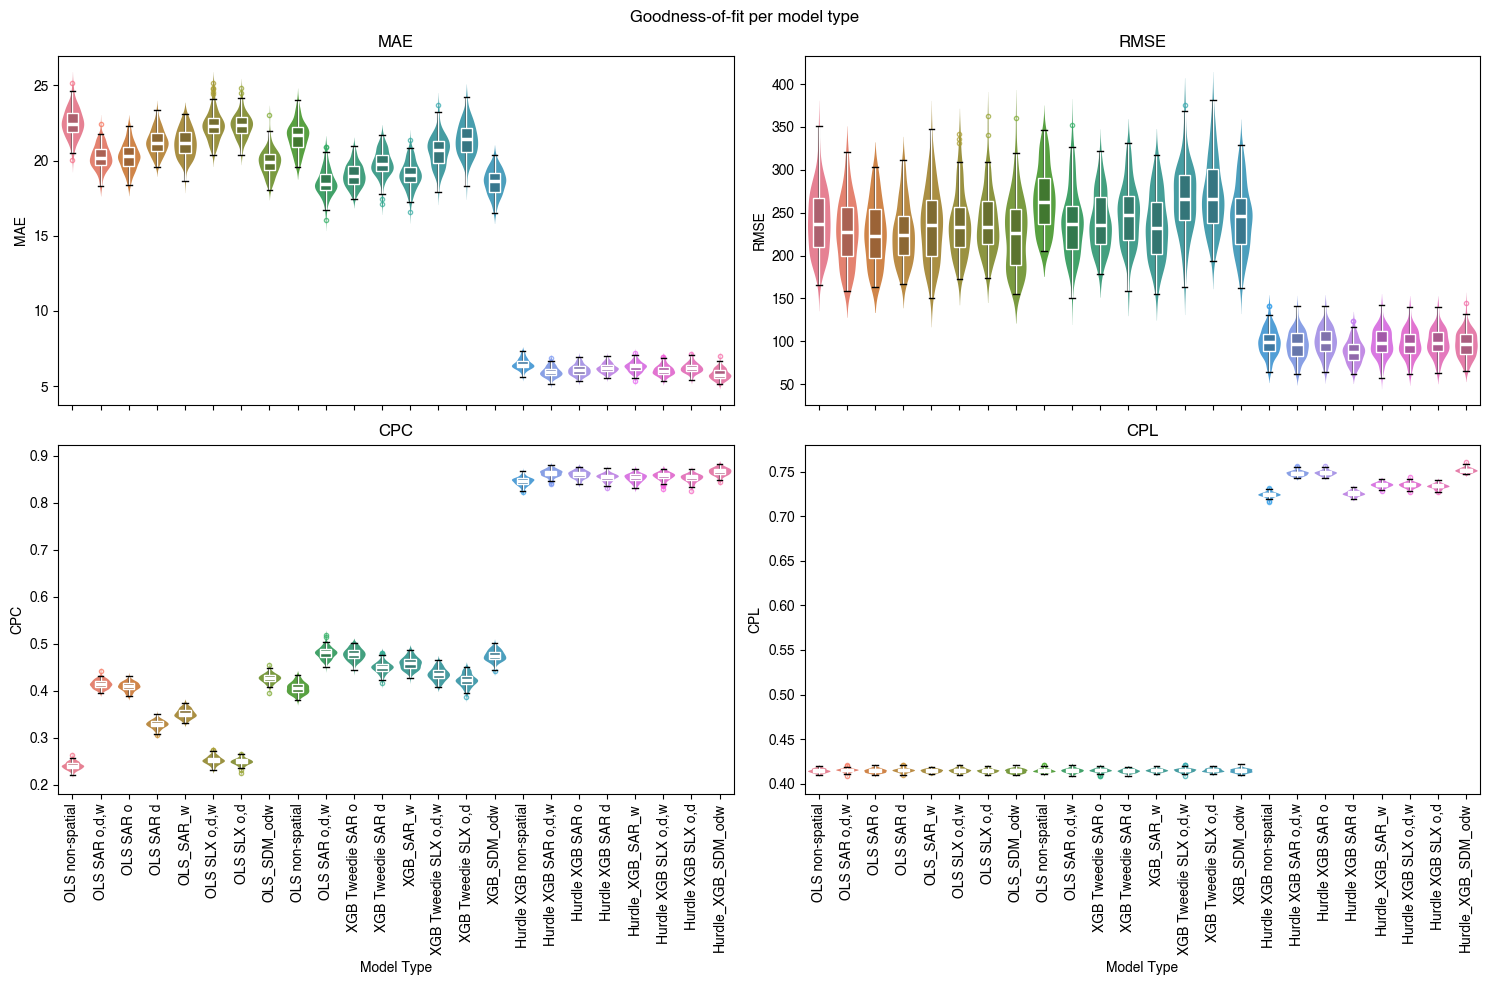

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes  # Import the brokenaxes module
import matplotlib.gridspec as gridspec
import matplotlib



# Define the metrics for which you want to create violin plots
metrics = [
    # 'R-squared',
           'MAE', 
           'RMSE', 
           # 'SQV', 
           # 'RATIO', 
           'CPC', 
           'CPL'
          ]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

# Flatten the axes array to iterate over them
axes = axes.flatten()

# Loop through each metric and create a violin plot
for i, metric in enumerate(metrics):

    ax = axes[i]  # Select the current axis
    sns.violinplot(x='model', y=metric, data=df_results_summary, hue='model',
            # inner='quartile',
               linewidth=0,
            ax=ax)

    sns.boxplot(x='model', y=metric, data=df_results_summary, hue='model', showbox=False, showcaps=False, fill=False, palette="husl",
                flierprops=dict(marker='.', markersize=6, alpha=0.75, fillstyle="full"),
                whiskerprops=dict(color=(0,0,0,0.5)),
                medianprops=dict(linewidth=0),
                ax=ax)
    
    sns.boxplot(x='model', y=metric, data=df_results_summary, hue='model',  showfliers=False, palette="hls",
                linecolor="w",
                # flierprops={"marker": "."},
                whiskerprops=dict(color="w"),
                capprops=dict(color="k"),
                # inner='quartile',
                   width=0.4,
                medianprops=dict(color="w", linewidth=2.5),
                    boxprops=dict(facecolor=(0,0,0,0.25)),
                ax=ax)
    
    ax.set_title(f'{metric}')
    ax.set_xlabel('Model Type')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels
    
    # Replace label names
    ax.set_xticklabels([label_replacements.get(label, label) for label in ordered_models])
    # ax.set_yticklabels([label_replacements.get(label, label) for label in ordered_models])
    
    

plt.suptitle("Goodness-of-fit per model type")
plt.tight_layout()
plt.show()
